In [15]:
import AFQ.data as afqd
import AFQ.viz.utils as plot_utils
import afqinsight as afqi
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from matplotlib.gridspec import  GridSpec
from matplotlib.legend_handler import HandlerTuple
from plot_formatting import set_size
from plot_utils import plot_coefs_on_bundle_cores
from sklearn.metrics import accuracy_score, r2_score, median_absolute_error, roc_auc_score
from string import Template
from textwrap import wrap

from groupyr.transform import GroupExtractor, GroupRemover

plt.style.use('tex')
fig_dir = "../reports/paper_figures"
latex_output_file = "../reports/manuscript/output.tex"

COLUMN_WIDTH = 246.0  # in points
FULL_TEXT_WIDTH = 510.0  # in points
FULL_TEXT_LENGTH = 660.0  # in points

In [16]:
pkl_suffixes = [
    "paper", "mean_only", "group_pca", "elastic_net", "pcr_lasso", "pure_lasso"
]
pkl_suffixes = [
    "_" + s + ".pkl" for s in pkl_suffixes
]
pkl_suffixes

models = ["SGL", "Bundle-mean lasso", "PCR-SGL", "Elastic net", "PCR Lasso", "Lasso"]

als_results = {}
wh_results = {}
hbn_results = {}
cc_results = {}

for key, suffix, results_key in zip(
    models,
    pkl_suffixes,
    [
        "bagging_stratify_trim0", "pure_lasso_trim0", "bagging_stratify_group_pca",
        "pure_lasso_trim0", "pure_lasso_trim0", "pure_lasso_trim0"
    ]
):
    with open("als_classify" + suffix, "rb") as fp:
        als_results[key] = pickle.load(fp)[results_key][0]

for key, suffix, results_key in zip(
    models,
    pkl_suffixes,
    [
        "bagging_target_transform_trim0",
        "bagging_target_transform_pure_lasso_trim0",
        "bagging_target_transform_group_pca",
        "bagging_target_transform_pure_lasso_trim0",
        "bagging_target_transform_pure_lasso_trim0",
        "bagging_target_transform_pure_lasso_trim0",
    ]
):
    with open("age_regression" + suffix, "rb") as fp:
        wh_results[key] = pickle.load(fp)[results_key][0]
        
for key, suffix, results_key in zip(
    models,
    pkl_suffixes,
    [
        "bagging_target_transform",
        "bagging_target_transform_bundle_mean_lasso",
        "bagging_target_transform_group_pca",
        "bagging_target_transform_elastic_net",
        "bagging_target_transform_pcr_lasso",
        "bagging_target_transform_pure_lasso",
    ]
):
    with open("hbn_regression" + suffix, "rb") as fp:
        hbn_results[key] = pickle.load(fp)[results_key][0]
        
for key, suffix, results_key in zip(
    models,
    pkl_suffixes,
    [
        "bagging_trim0",
        "bagging_pure_lasso_trim0",
        "bagging_group_pca",
        "bagging_pure_lasso_trim0",
        "bagging_pure_lasso_trim0",
        "bagging_pure_lasso_trim0",
    ]
):
    with open("camcan_regression" + suffix, "rb") as fp:
        cc_results[key] = pickle.load(fp)[results_key][0]

In [17]:
def get_cv_split_performance(results, performance_metric, dataset_name):
    metrics = [
        {
            "cv": cv_idx,
            "metric": cv_res[performance_metric],
            "metric_name": performance_metric,
            "dataset": dataset_name,
            "model": model,
        } for model in results.keys()
        for cv_idx, cv_res in results[model].items()
    ]
    return pd.DataFrame(metrics)

df = pd.concat([
    get_cv_split_performance(
        results = _res,
        performance_metric=_metric,
        dataset_name=_dname,
    ) for _res, _metric, _dname in zip(
        [als_results, wh_results, hbn_results, cc_results],
        ["test_accuracy", "test_r2", "test_r2", "test_r2"],
        ["ALS", "WH", "HBN", "Cam-CAN"],
    )
])

In [18]:
df

,cv,metric,metric_name,dataset,model
0,0,0.800000,test_accuracy,ALS,SGL
1,1,0.800000,test_accuracy,ALS,SGL
2,2,0.800000,test_accuracy,ALS,SGL
3,3,0.800000,test_accuracy,ALS,SGL
4,4,0.800000,test_accuracy,ALS,SGL
...,...,...,...,...,...
25,0,0.643564,test_r2,Cam-CAN,Lasso
26,1,0.773331,test_r2,Cam-CAN,Lasso
27,2,0.707928,test_r2,Cam-CAN,Lasso
28,3,0.724492,test_r2,Cam-CAN,Lasso


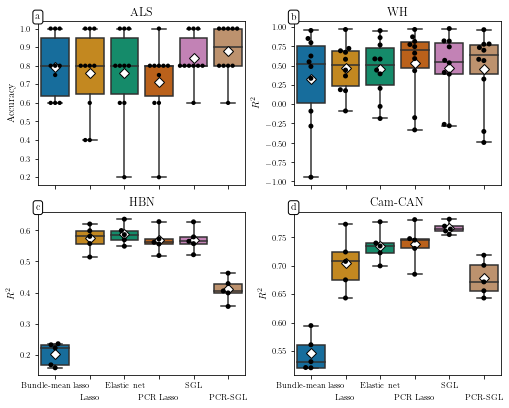

In [22]:
figsize = set_size(width=FULL_TEXT_WIDTH, subplots=(2.5, 2))
fig, ax = plt.subplots(2, 2, figsize=figsize, sharex=True)

fig.tight_layout(w_pad=2.5, h_pad=2)

hue_order = ["Bundle-mean lasso", "Lasso", "Elastic net", "PCR Lasso", "SGL", "PCR-SGL"]
sns.swarmplot(data=df[df["dataset"] == "ALS"], x="model", y="metric", color="black",
              dodge=True, ax=ax[0, 0], size=4.3, order=hue_order)
sns.swarmplot(data=df[df["dataset"] == "WH"], x="model", y="metric", color="black",
              dodge=True, ax=ax[0, 1], order=hue_order)
sns.swarmplot(data=df[df["dataset"] == "HBN"], x="model", y="metric", color="black",
              dodge=True, ax=ax[1, 0], order=hue_order)
sns.swarmplot(data=df[df["dataset"] == "Cam-CAN"], x="model", y="metric", color="black",
              dodge=True, ax=ax[1, 1], order=hue_order)

mean_marker = "D"
mean_size = "7.5"

sns.boxplot(data=df[df["dataset"] == "ALS"], x="model", y="metric",
            whis=np.inf, ax=ax[0, 0], order=hue_order, palette="colorblind",
            showmeans=True,
            meanprops={"marker":mean_marker,
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":mean_size}
           )
sns.boxplot(data=df[df["dataset"] == "WH"], x="model", y="metric",
            whis=np.inf, ax=ax[0, 1], order=hue_order, palette="colorblind",
            showmeans=True,
            meanprops={"marker":mean_marker,
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":mean_size}
           )
sns.boxplot(data=df[df["dataset"] == "HBN"], x="model", y="metric",
            whis=np.inf, ax=ax[1, 0], order=hue_order, palette="colorblind",
            showmeans=True,
            meanprops={"marker":mean_marker,
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":mean_size}
           )
sns.boxplot(data=df[df["dataset"] == "Cam-CAN"], x="model", y="metric",
            whis=np.inf, ax=ax[1, 1], order=hue_order, palette="colorblind",
            showmeans=True,
            meanprops={"marker":mean_marker,
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":mean_size}
           )

handles, labels = ax[0, 0].get_legend_handles_labels()

for _ax in ax.flatten():
    _ax.set_xlabel("")
    
ax[0, 0].set_ylabel("Accuracy")
ax[0, 1].set_ylabel("$R^2$")
for _ax in ax[1]:
    _ax.set_ylabel("$R^2$")
    for tick in _ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(15)
        
for _ax, text in zip(ax.flatten(), ["ALS", "WH", "HBN", "Cam-CAN"]):
    _ax.set_title(text)
    
for _ax, alpha in zip(ax.flatten(), "abcd"):
    _ax.text(  # position text relative to Axes
        0.0, 1.025, alpha,
        ha="center", va="center",
        transform=_ax.transAxes,
        fontweight="bold",
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=0.25"
        )
    )

    
fig.savefig(op.join(fig_dir, "model_performance.pdf"), bbox_inches="tight")